In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import os
import sys
sys.path.append("../../")
import helpers

# Camera Calibration
One of the core concepts in computer graphics is going from 2D to 3D or the other way around. In the physical world cameras project the world they see through a set of lenses onto an image sensor. Similarly, in the virtual world we create a mathematical models that describe how points in 3D "world space" are mapped onto the virtual sensor (your screen).


## Pinhole Camera
The simplest and most common model is the pinhole camera model. The camera model gets its name from the "pinhole" camera that it is trying to model: a (infinitely) small hole in the wall of a (shoe)box where all light rays converge. In the real-world case the sensor would be positioned behing the pinhole and the image will appear upside down. In the virtual model however we assume that the image plane is positioned in front of the camera.
![](https://www.scratchapixel.com/images/upload/cameras/cameraobscura.png)
![](https://www.scratchapixel.com/images/upload/cameras/pinholecam4.png)


### Perspective Projection
The pinhole model applies perspective projection to the image. That is: far away objects look smaller than objects that are nearby. Assume that the camera is centered at the origin and is looking along the z-axis. To achieve perspective projection we need to divide the x and y coordinates of any point by its z coordinate. We cannot achieve this with regular matrix math because it gives us no way of dividing by z. A way we aleviate this problem is by working in the homogeneous coordinate system. Homogeneous coordinates are similar to regular coordinates except that we give them an extra "unused" dimension. Whenever we convert from regular to homogeneous coordinates we set the coordinate along this dimension to 1. When we convert to regular coordinates we make sure to divide the position along all axes by the position along this final axis.
$$
\vec{v}=
\begin{pmatrix}
x \\
y \\
z \\
1
\end{pmatrix}
$$

By setting the final axis to the position along the $z$ axis (using a transformation matrix) we effectively divide by Z (when converting back to regular coordinates). So the perspective transformation of our simple pinhole camera model can be described by a simple 3x4 matrix ($f$ is the focal length of the camera):
$$
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
=
\begin{pmatrix}
f & 0 & 0 &0  \\
0 & f & 0 &0 \\
0 & 0 & 1 &0 
\end{pmatrix}
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
$$

### Rotation and translation
In the previous example we assumed that the camera was centered at the origin and it was looking along the z-axis. This might be fine for some use cases but assume that we have two cameras (at different positions/orientations): only one can be at the origin. We need to transform the world such that it aligns with the camera. In a virtual world we place the camera in our world by moving/rotating it away from the origin. So to move the camera to the origin we need to transform the world by the inverse of this matrix. 

Ignoring scaling (and skewing) such a transformation consists of a rotation and translation (movement). While rotations can be described in matrix form with regular coordinates, translations cannot. The problem we face is that we cannot describe a fixed translation (offset) as a multiplication with a points coordinates (which vary from point to point). Again homogeneous coordinates come to the rescue by adding a known (fixed) value to the input coordinates. Assuming that the position along the final axis is $1$ the following matrix describes a translation in 3D:
$$
\begin{pmatrix}
x+t_x \\
y+t_y \\
z+t_z \\
1
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 & t_x \\
0 & 1 & 0 & t_y \\
0 & 0 & 1 & t_z \\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
z \\
1
\end{pmatrix}
$$

Finally, we can describe our full pinhole camera model with the following equation:
$$
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
= 
\begin{pmatrix}
f & 0 & 0 \\
0 & f & 0 \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0 & t_x \\
0 & 1 & 0 & t_y \\
0 & 0 & 1 & t_z \\
%0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
r_{11} & r_{12} & r_{13} & 0 \\
r_{21} & r_{22} & r_{23} & 0\\
r_{31} & r_{32} & r_{33} & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
\\
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
= 
\begin{pmatrix}
f & 0 & 0 \\
0 & f & 0 \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y\\
r_{31} & r_{32} & r_{33} & t_z
\end{pmatrix}
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
\\
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
= 
K
[R|t]
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
\\
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
= 
P
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
$$

In computer vision we say that the projection matrix $K$ contains the camera *intrinsics* and that the rotation/translation matrix $[R|t]$ contains the camera *extrinsics*.

### Exercise 5 (2 points)
Assuming that we know the full camera matrix $P$ which transforms 3D points into 2D screen coordinates. Implement a function that takes this matrix and a set of 3D points and transforms those points into pixel coordinates.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
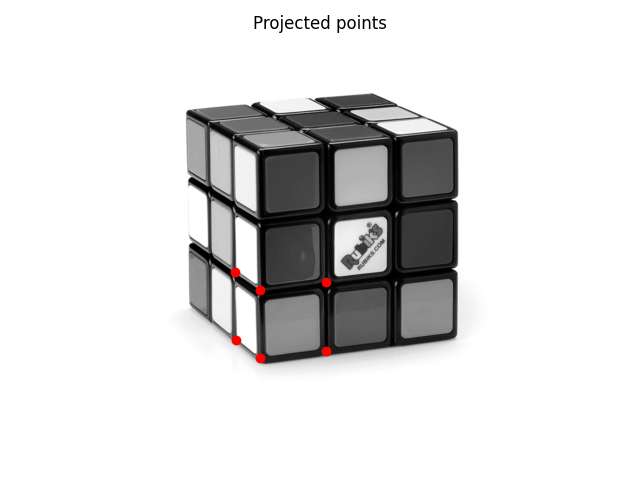

In [2]:
XYZ = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]])

def project_points(P, XYZ):
    projected_points = np.zeros((len(XYZ), 2))
    ones = np.ones(XYZ.shape[0])
    XYZ_homo = np.c_[XYZ, ones]

    xy_homo = XYZ_homo @ P.T 
    xy_homo = xy_homo / xy_homo[:,2,None]
    projected_points = xy_homo[:,:-1]
    return projected_points

P = np.load(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube_matrix.npy"))
projected_corners = project_points(P, XYZ)

rubiks_cube_image = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube.png"))

fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Projected points")
ax.imshow(rubiks_cube_image, cmap="gray")
ax.scatter(projected_corners[:,0], projected_corners[:,1], c="red")
fig.tight_layout()
plt.show()

### Tests of exercise 5
Your method should project the points (red dots) onto the visible corners of the bottom cube that is closest to the camera.

### Exercise 6 (1 point)
To get feeling of how the 3D coordinate system works you should find the 3D coordinates of the 7 visible corners of the Rubiks cube. Add the coordinates of the points to array `XYZ`. If you implemented the previous exercise correctly then you may use the visuals to guide you. The tests for this exercise are hidden because they contain the answers.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
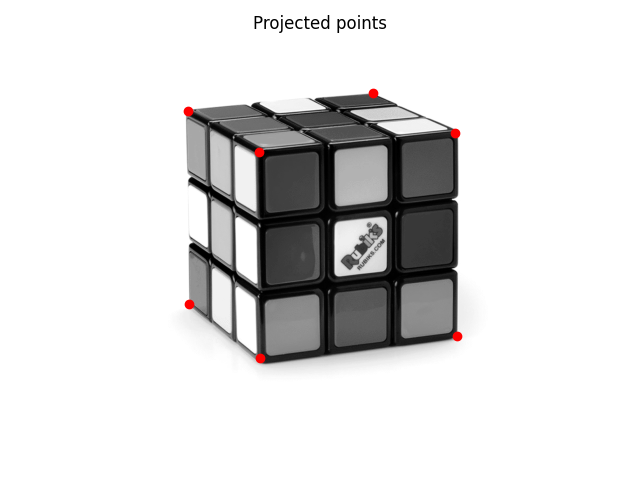

In [3]:
XYZ = np.array([[0, 0, 0],
                [0, 0, 3],
                [0, 3, 3],
                [0, 3, 0],
                [3, 3, 3],
                [3, 0, 0],
                [3, 3, 0],
      ])

P = np.load(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube_matrix.npy"))
projected_corners = project_points(P, XYZ)

rubiks_cube_image = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube.png"))

fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Projected points")
ax.imshow(rubiks_cube_image, cmap="gray")
ax.scatter(projected_corners[:,0], projected_corners[:,1], c="red")
fig.tight_layout()
plt.show()

### Tests for exercise 6
Your array should contain the 3D coordinates of the 7 visible corners of the Rubiks cube.

In [4]:
assert(XYZ.shape == (7, 3))

## Finding the camera matrix
Assume that we have found a couple of points in the image of which we know the 3D (physical) position, either through manual labor or by programmatically (e.g. corner detection). With this information you should be able to find the (3x4) camera matrix $P=K[R|t]$ that transforms 3D points onto the image plane.

### Exercise 7 (3 points)
Write a function that given the set of 3D points `XYZ` and their corresponding position on the image plane (2D) `xy` computes the matrix $P$ that projects 3D points onto the image plane. Formulate your problem as a linear system $A\vec{x}=\vec{b}$ and solve it using `np.linalg.lstsq(A, b)[0]`.

$P$ has 3 rows and 4 columns so there are 12 unknowns in total. However, due to the perspective division, we could apply any scaling factor to the matrix and we would still get the same transform (see lecture). We can therefor fix one of the values in the matrix at 1 such that we have to solve for 11 unknowns. *Hint*: Each pair of 3D/2D points should add 2 contraints (rows in matrix $A$) to the linear system.

**NOTE:** Your solution does not have to exactly match the reference. As long as the green points (estimation positions) are close to the red ones (actual positions).

[ 0. -5.  5.  1.] [213.1027 170.0499]
[[-5.0000000e+00  5.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00
   1.0655135e+03 -1.0655135e+03 -2.1310270e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -5.0000000e+00  5.0000000e+00  1.0000000e+00 -0.0000000e+00
   8.5024950e+02 -8.5024950e+02 -1.7004990e+02]] [-0.  0.]
[ 0. -3.  5.  1.] [258.1908 181.3219]
[[-3.000000e+00  5.000000e+00  1.000000e+00  0.000000e+00 -5.000000e+00
   5.000000e+00  1.000000e+00 -0.000000e+00  7.745724e+02 -1.290954e+03
  -2.581908e+02]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -3.000000e+00
   5.000000e+00  1.000000e+00 -0.000000e+00  5.439657e+02 -9.066095e+02
  -1.813219e+02]] [-0.  0.]
[ 0. -1.  5.  1.] [306.41   193.8464]
[[-1.000000e+00  5.000000e+00  1.000000e+00  0.000000e+00 -3.000000e+00
   5.000000e+00  1.000000e+00 -0.000000e+00  3.064100e+02 -1.532050e+03
  -3.064100e+02]
 [ 0.000000e+00  0.000000e+00  0.0000

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
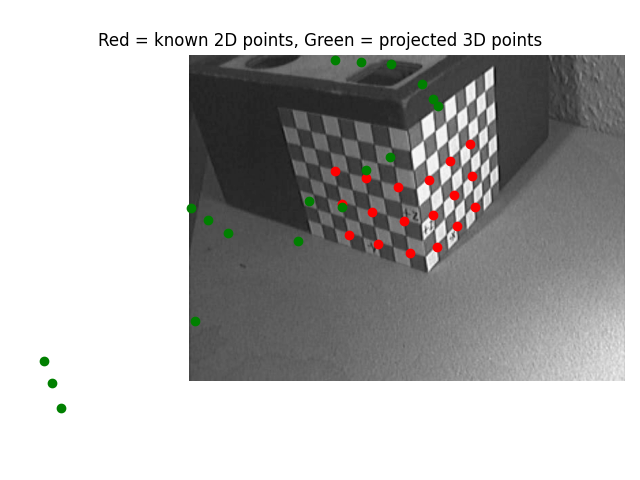

In [5]:
xy = np.array([
            [ 213.1027,  170.0499], [ 258.1908,  181.3219],
            [ 306.41  ,  193.8464], [ 351.498 ,  183.8268],
            [ 382.8092,  155.6468], [ 411.6155,  130.5978],
            [ 223.7485,  218.2691], [ 267.5841,  230.7935],
            [ 314.5509,  244.5705], [ 357.7603,  235.1771],
            [ 387.819 ,  205.1184], [ 415.3728,  178.1908],
            [ 234.3943,  263.9834], [ 276.9775,  277.1341],
            [ 323.318 ,  291.5372], [ 363.3963,  282.1438],
            [ 392.8288,  251.4589], [ 419.1301,  223.9051]])
XYZ = np.array([[0, -5, 5], [0, -3, 5], [0, -1, 5], [-1, 0, 5],
             [-3, 0, 5], [-5, 0, 5], [0, -5, 3], [0, -3, 3],
             [0, -1, 3], [-1, 0, 3], [-3, 0, 3], [-5, 0, 3],
             [0, -5, 1], [0, -3, 1], [0, -1, 1], [-1, 0, 1],
             [-3, 0, 1], [-5, 0, 1]])

# TIP VOOR JULLIE, HAAL DIT WEG WANNEER WE HET GAAN INLEVEREN
# https://web.stanford.edu/class/cs231a/course_notes/01-camera-models.pdf
def compute_P(XYZ, xy):
    assert(len(XYZ) == len(xy))
    ps = 7
    XYZ, xy = XYZ[:], xy[:]


    ones = np.ones(XYZ.shape[0])
    XYZ_homo = np.c_[XYZ, ones]
    
    A = np.zeros((2 * len(xy), 11))
    b = np.zeros(2 * len(xy))
    i = 0

    for p, pp in zip(XYZ_homo, xy):
        print(p, pp)
        A[i, :3] = p[1:]
        A[i, 7:] = p * -pp[0]
        b[i] = -p[0]

        A[i+1, 3:7] = p
        A[i+1, 7:] = p * -pp[1]
        
        print(A[i:i+2], b[i:i+2])
        i += 1

    P = np.linalg.lstsq(A, b)[0]
    P = np.insert(P, 0, 1)
    return P.reshape(3, 4)

# Make Python shut up about "FutureWarning: `rcond` parameter will change ..."
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    P = compute_P(XYZ, xy) # Use point pairs XYZ/xy to guess the matrix
    print(P)
    
# Project XYZ to the screen to confirm
projected_corners = project_points(P, XYZ)

checkerboard_cube_image = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "calibration", "checkerboard_cube.jpg"))

fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Red = known 2D points, Green = projected 3D points")
ax.imshow(checkerboard_cube_image, cmap=plt.get_cmap('gray'))
ax.scatter(xy[:,0], xy[:,1], c="red")
ax.scatter(projected_corners[:,0], projected_corners[:,1], c="green")
fig.tight_layout()
plt.show()

### Tests for exercise 7
This tests if the correctness of the computed matrix by projecting the points to screen space (using your solution to `project_points` from exercise 5). The points that were used for calibration should be projected very close to their actual positions.

In [6]:
# === Points used for both calibration & testing ===
xy = np.array([[ 213.1027,  170.0499], [ 258.1908,  181.3219],
            [ 306.41  ,  193.8464], [ 351.498 ,  183.8268],
            [ 382.8092,  155.6468], [ 411.6155,  130.5978],
            [ 223.7485,  218.2691], [ 267.5841,  230.7935],
            [ 314.5509,  244.5705], [ 357.7603,  235.1771],
            [ 387.819 ,  205.1184], [ 415.3728,  178.1908],
            [ 234.3943,  263.9834], [ 276.9775,  277.1341],
            [ 323.318 ,  291.5372], [ 363.3963,  282.1438],
            [ 392.8288,  251.4589], [ 419.1301,  223.9051]])
XYZ = np.array([[0, -5, 5], [0, -3, 5], [0, -1, 5], [-1, 0, 5],
             [-3, 0, 5], [-5, 0, 5], [0, -5, 3], [0, -3, 3],
             [0, -1, 3], [-1, 0, 3], [-3, 0, 3], [-5, 0, 3],
             [0, -5, 1], [0, -3, 1], [0, -1, 1], [-1, 0, 1],
             [-3, 0, 1], [-5, 0, 1]])


# Make Python shut up about "FutureWarning: `rcond` parameter will change ..."
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    P = compute_P(XYZ, xy) # Use point pairs XYZ/xy to guess the matrix

# Project XYZ to the screen to confirm
projected_points = project_points(P, XYZ)
# Input points projected back to the screen should have a low error
print(f"Average squared distance between actual calibration points and reprojected points: {helpers.SSD_per_pixel(xy, projected_points)}")
assert(helpers.SSD_per_pixel(xy, projected_points) < 0.15)


[ 0. -5.  5.  1.] [213.1027 170.0499]
[[-5.0000000e+00  5.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00
   1.0655135e+03 -1.0655135e+03 -2.1310270e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -5.0000000e+00  5.0000000e+00  1.0000000e+00 -0.0000000e+00
   8.5024950e+02 -8.5024950e+02 -1.7004990e+02]] [-0.  0.]
[ 0. -3.  5.  1.] [258.1908 181.3219]
[[-3.000000e+00  5.000000e+00  1.000000e+00  0.000000e+00 -5.000000e+00
   5.000000e+00  1.000000e+00 -0.000000e+00  7.745724e+02 -1.290954e+03
  -2.581908e+02]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -3.000000e+00
   5.000000e+00  1.000000e+00 -0.000000e+00  5.439657e+02 -9.066095e+02
  -1.813219e+02]] [-0.  0.]
[ 0. -1.  5.  1.] [306.41   193.8464]
[[-1.000000e+00  5.000000e+00  1.000000e+00  0.000000e+00 -3.000000e+00
   5.000000e+00  1.000000e+00 -0.000000e+00  3.064100e+02 -1.532050e+03
  -3.064100e+02]
 [ 0.000000e+00  0.000000e+00  0.0000

AssertionError: 